In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(SeuratDisk)
library(harmony)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
})
set.seed(123)

In [2]:
# load samples
sample_human <- readRDS("sample_human_annotated.rds")
sample_human
sample_mouse <- readRDS("sample_mouse_annotated.rds")
sample_mouse

An object of class Seurat 
57127 features across 4158 samples within 2 assays 
Active assay: SCT (20526 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, tsne, umap

An object of class Seurat 
48763 features across 5112 samples within 2 assays 
Active assay: SCT (16478 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

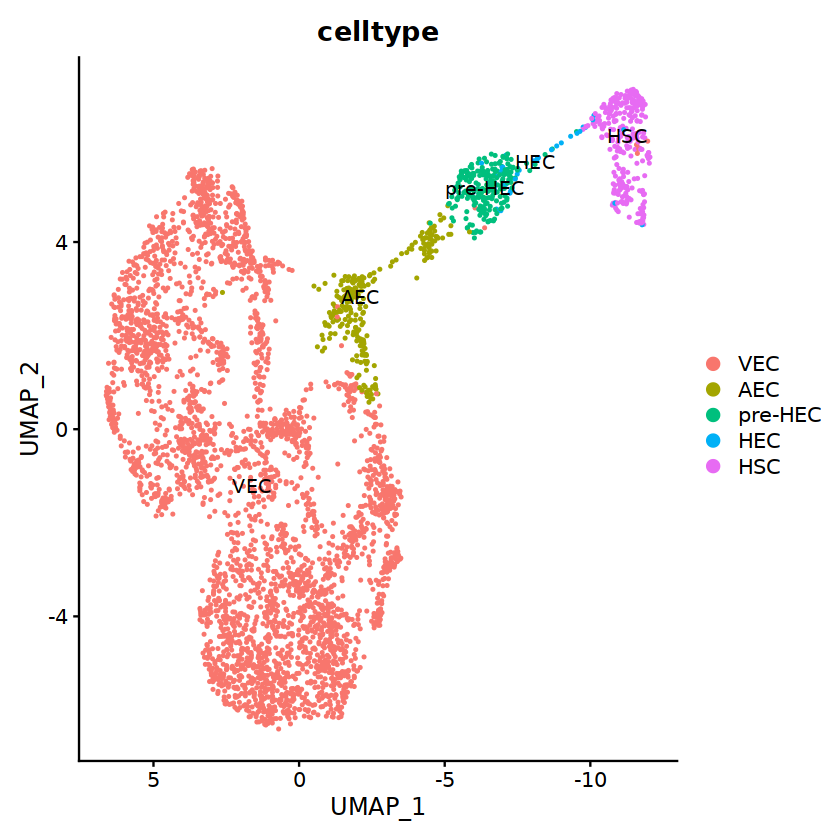

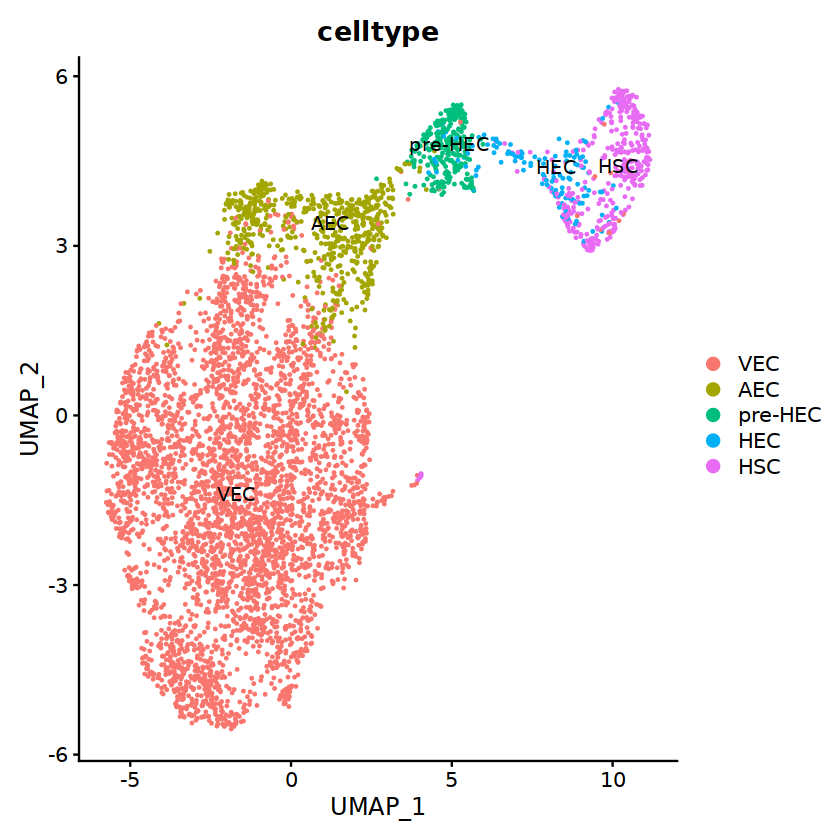

In [3]:
# umap of human and mouse EHT
DimPlot(sample_human, reduction = "umap", group.by = "celltype", label = T) + scale_x_reverse()
sample_mouse$celltype <- factor(sample_mouse$celltype, levels = c("VEC", "AEC", "pre-HEC", "HEC", "HSC"))
DimPlot(sample_mouse, reduction = "umap", group.by = "celltype", label = T)

In [4]:
# convert mouse gene to human homology
mouse_human_gene <- read.csv("mouse2human_gene_homology.csv", header = T, row.names = 1)
rownames(mouse_human_gene) <- mouse_human_gene$MGI.symbol

count_mouse <- GetAssayData(sample_mouse, slot = "counts", assay = "RNA")
count_mouse <- as.data.frame(count_mouse[intersect(rownames(sample_mouse), mouse_human_gene$MGI.symbol), ])
count_mouse$gene <- mouse_human_gene[rownames(count_mouse), ]$HGNC.symbol
count_mouse <- count_mouse[!duplicated(count_mouse$gene), ]
rownames(count_mouse) <- count_mouse$gene
count_mouse$gene <- NULL

count_human <- GetAssayData(sample_human, slot = "counts", assay = "RNA")[intersect(rownames(count_mouse), rownames(sample_human)), ]
dim(count_human)
count_mouse <- count_mouse[intersect(rownames(count_mouse), rownames(sample_human)), ]
dim(count_mouse)

[1] 12828  4158

[1] 12828  5112

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


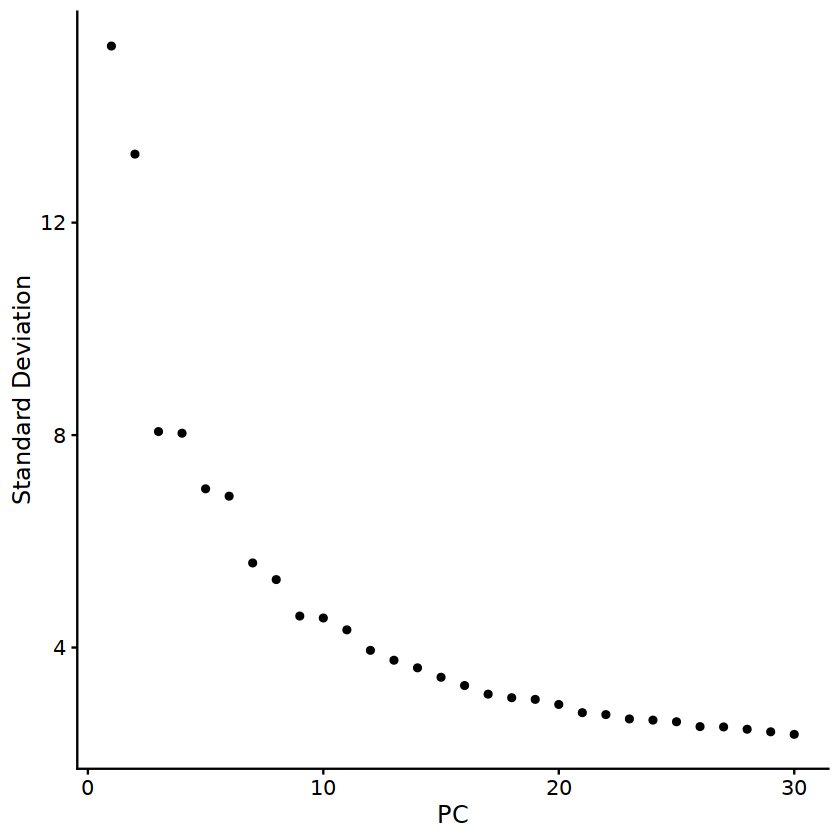

In [5]:
# remove batch effect and integrate
sample_human_new <- CreateSeuratObject(count_human, project = "human")
sample_mouse_new <- CreateSeuratObject(count_mouse, project = "mouse")

scList <- list(sample_human_new, sample_mouse_new)

options(future.globals.maxSize = 8000 * 1024^2)
scList <- lapply(X = scList, FUN = SCTransform, method = "glmGamPoi", verbose = FALSE)

features <- SelectIntegrationFeatures(object.list = scList, nfeatures = 3000, verbose = FALSE)
scList <- PrepSCTIntegration(object.list = scList, anchor.features = features, verbose = FALSE)

sc.anchors <- FindIntegrationAnchors(object.list = scList, normalization.method = "SCT", anchor.features = features, verbose = FALSE)
sc.combined.sct <- IntegrateData(anchorset = sc.anchors, normalization.method = "SCT", verbose = FALSE)

sc.combined.sct <- RunPCA(sc.combined.sct, verbose = FALSE)
ElbowPlot(object=sc.combined.sct, ndims=30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


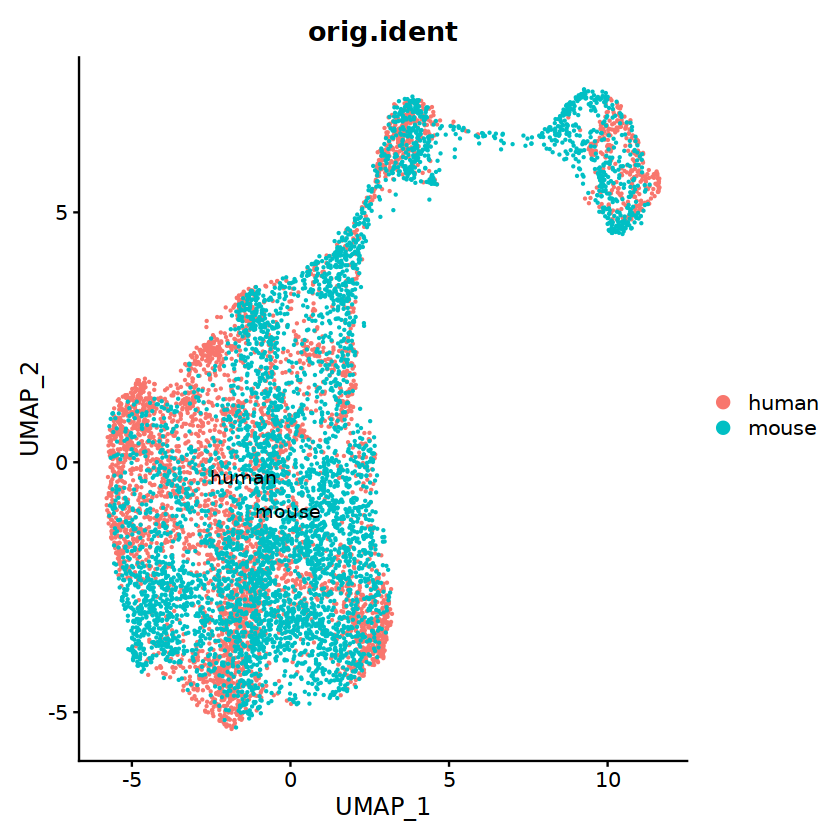

In [6]:
# dimension reduction and clustering
pca_dims = 1:28
sc.combined.sct <- RunTSNE(sc.combined.sct, reduction = "pca", dims = pca_dims, verbose = FALSE)
sc.combined.sct <- RunUMAP(sc.combined.sct, reduction = "pca", dims = pca_dims, verbose = FALSE)
sc.combined.sct = FindNeighbors(object=sc.combined.sct, dims=pca_dims, verbose = FALSE)
sc.combined.sct = FindClusters(object=sc.combined.sct, resolution=0.5, verbose = FALSE)
DimPlot(sc.combined.sct, label=TRUE, reduction="umap", group.by = "orig.ident")

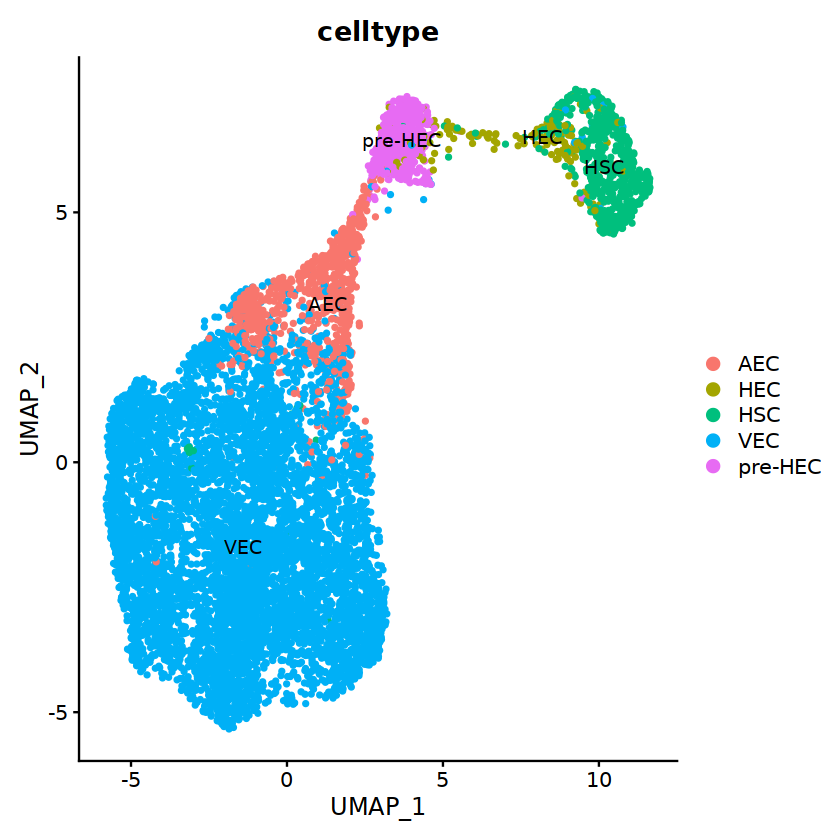

In [7]:
# celltype assignment
meta.combined <- rbind(sample_human@meta.data[, c(1:3, 7)], sample_mouse@meta.data[, c(1:3, 8)])
sc.combined.sct$celltype <- as.character(meta.combined$celltype)
DimPlot(sc.combined.sct, label=TRUE, reduction="umap", group.by = "celltype", pt.size = 1)

In [8]:
# save the data
saveRDS(sc.combined.sct, "sample_EHT_integrated.rds")

In [9]:
# load the data
sample <- readRDS("sample_EHT_integrated.rds")

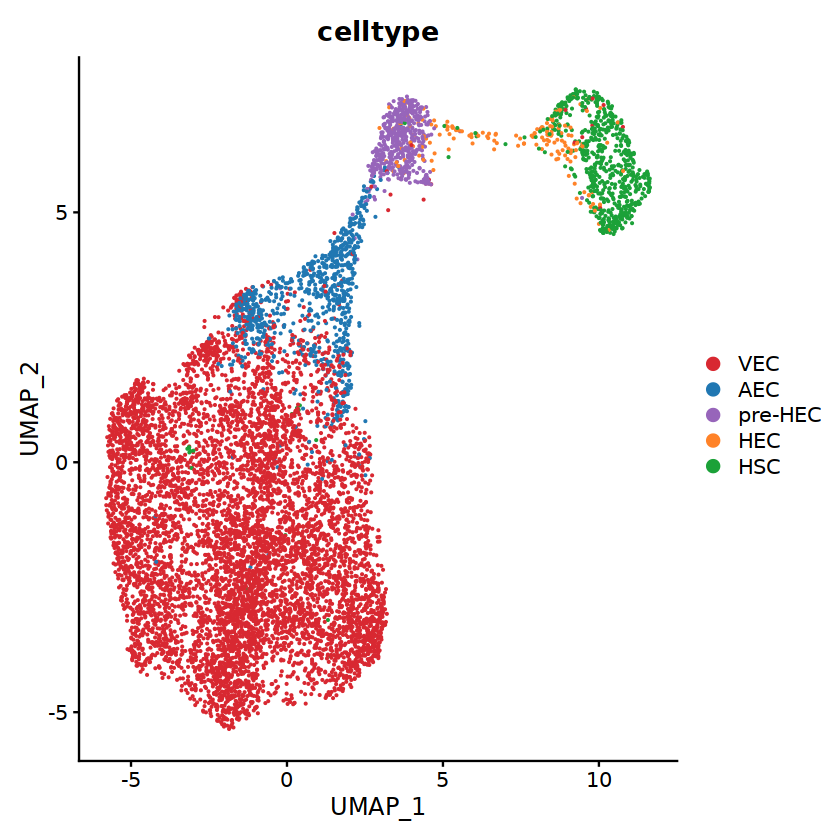

In [10]:
# plot the celltype umap
sample$celltype <- as.character(sample$celltype)
sample$celltype <- factor(sample$celltype, levels = c("VEC", "AEC", "pre-HEC", "HEC", "HSC"))
celltype_col <- c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")
DimPlot(sample, label=F, reduction = "umap", group.by = "celltype", cols = celltype_col, pt.size = 0.1)
ggsave("figure/umap_EHT_integrated.pdf", width = 6, height = 5)

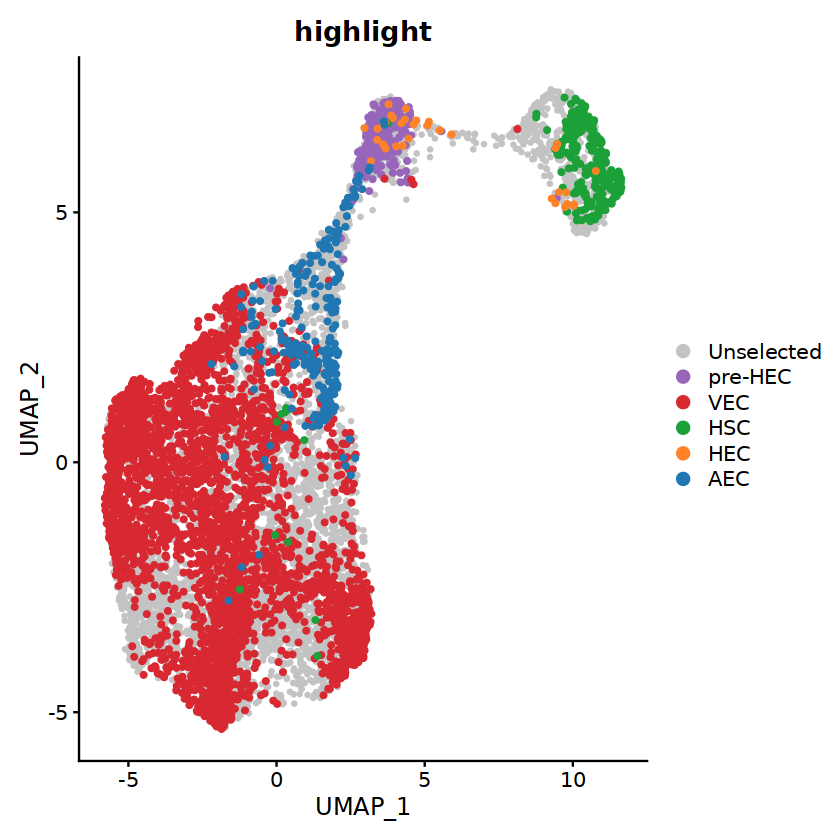

In [11]:
# project the human sample on integrated umap
human_vec <- rownames(sample@meta.data[sample$orig.ident == "human" & sample$celltype == "VEC", ])
human_aec <- rownames(sample@meta.data[sample$orig.ident == "human" & sample$celltype == "AEC", ])
human_prehec <- rownames(sample@meta.data[sample$orig.ident == "human" & sample$celltype == "pre-HEC", ])
human_hec <- rownames(sample@meta.data[sample$orig.ident == "human" & sample$celltype == "HEC", ])
human_hsc <- rownames(sample@meta.data[sample$orig.ident == "human" & sample$celltype == "HSC", ])
human_eht_list <- list(VEC = human_vec, AEC = human_aec, preHEC = human_prehec, HEC = human_hec, HSC = human_hsc)
names(human_eht_list)[3] <- "pre-HEC"
DimPlot(sample, label=F, reduction="umap", group.by = "celltype", pt.size = 0.8, cells.highlight = human_eht_list, cols.highlight = c("#9765BA", "#D82831", "#1BA138", "#FF8228", "#2077B2"), sizes.highlight = 1.2)

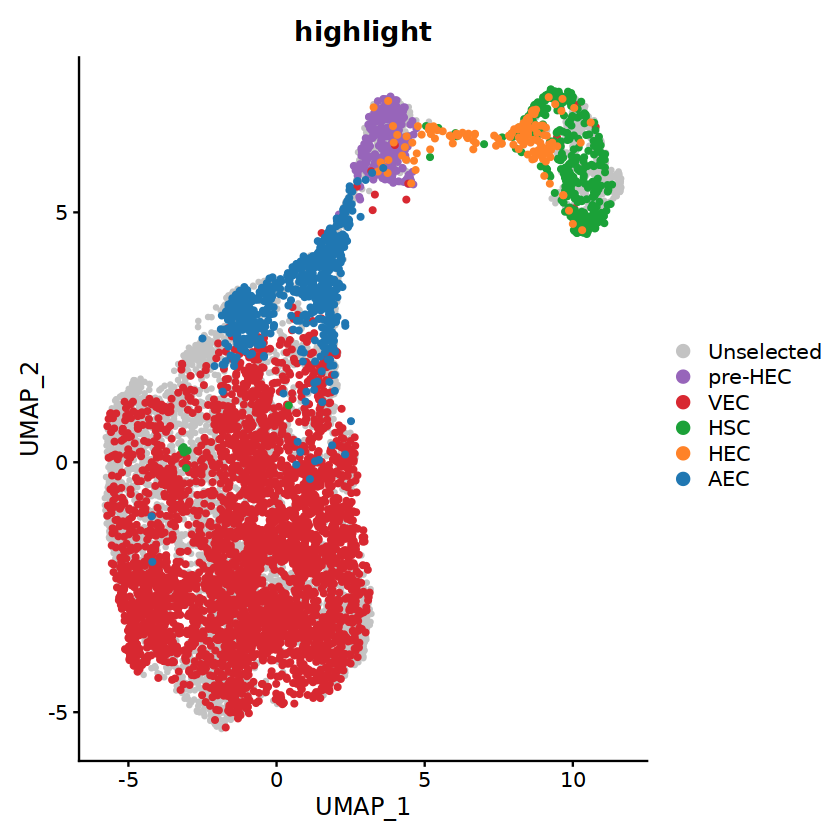

In [12]:
# project the mouse sample on integrated umap
mouse_vec <- rownames(sample@meta.data[sample$orig.ident == "mouse" & sample$celltype == "VEC", ])
mouse_aec <- rownames(sample@meta.data[sample$orig.ident == "mouse" & sample$celltype == "AEC", ])
mouse_prehec <- rownames(sample@meta.data[sample$orig.ident == "mouse" & sample$celltype == "pre-HEC", ])
mouse_hec <- rownames(sample@meta.data[sample$orig.ident == "mouse" & sample$celltype == "HEC", ])
mouse_hsc <- rownames(sample@meta.data[sample$orig.ident == "mouse" & sample$celltype == "HSC", ])
mouse_eht_list <- list(VEC = mouse_vec, AEC = mouse_aec, preHEC = mouse_prehec, HEC = mouse_hec, HSC = mouse_hsc)
names(mouse_eht_list)[3] <- "pre-HEC"
DimPlot(sample, label=F, reduction="umap", group.by = "celltype", pt.size = 0.8, cells.highlight = mouse_eht_list, cols.highlight = c("#9765BA", "#D82831", "#1BA138", "#FF8228", "#2077B2"), sizes.highlight = 1.2)

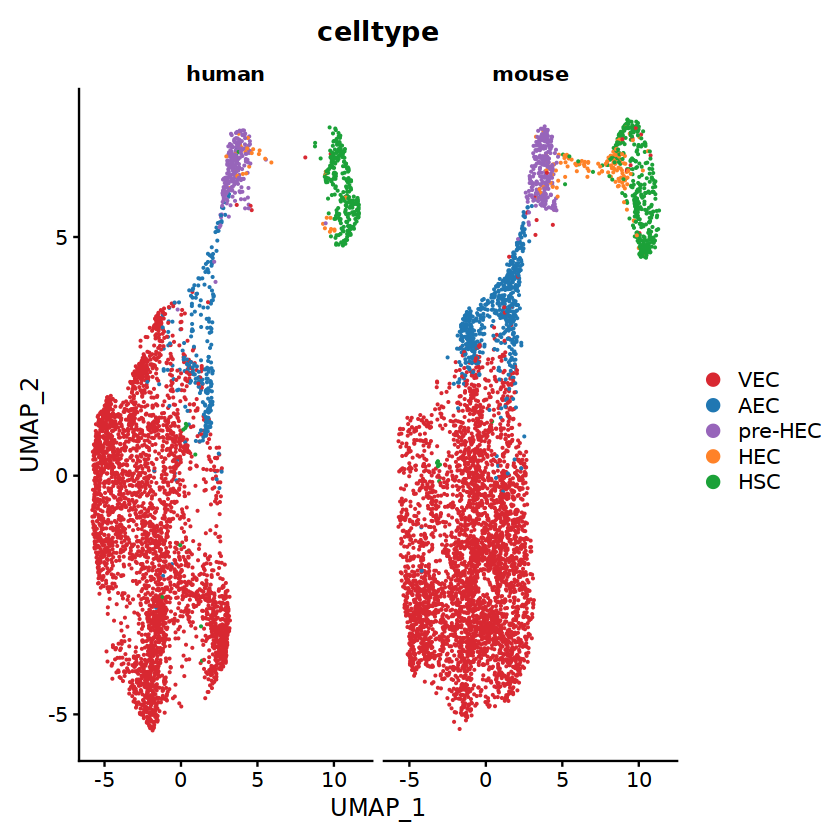

In [13]:
# umap split by species
DimPlot(sample, label=F, reduction="umap", group.by = "celltype", cols = celltype_col, pt.size = 0.1, split.by = "orig.ident")
ggsave("figure/umap_EHT_integrated_by_species.pdf", width = 10, height = 5)

In [14]:
# celltype similarity
library(pheatmap)
sample$celltype_species <- paste(sample$orig.ident, sample$celltype, sep = "_")
averageExpr <- AverageExpression(sample, assays = "integrated", group.by = "celltype_species", features = VariableFeatures(sample))
pheatmap(cor(averageExpr$integrated)[c(4,1,5,2,3), c(9,6,10,7,8)], cluster_cols = F, cluster_rows = F, filename = "figure/EHT_cell_similarity_human_mouse.pdf")

In [15]:
# plot the EHT scorecard for human and mouse
EHT_scorecard <- c(#"CDH5","RUNX1","PTPRC","SPN","CD44","ITGA2B","HLF","GFI1","MLLT3","HOXA9","MKI67", # Landmarks
                 "NRP2","NR2F2", # VEC
                 "NID2","PRND","ESM1","PDGFB", # AEC enriched
                 "GJA4","HEY1","DLL4","CXCR4","SOX17","SMAD6","GJA5", # AEC
                 "TMEM100","EDN1","HEY2","GATA6","BMX","CYP26B1","FBN2","PALMD","LTBP4","SULF1","IL33", # pre-HEC
                 "ADGRG6","COL23A1","TMCC3","DKK1", # pre-HEC and HEC
                 "ELN","GATA3","GBP4","NKX2-3","PROCR", # pre-HEC, HEC and HSC
                 "MYCN","KCNK17", # HE and HSC
                 "CD44","HOXA9","MLLT3","RUNX1","MYB","KIT","GFI1","HLF","ITGA2B","PTPRC","SPN","STAT5A","SMIM24","RAB27B","SPINK2") # HSC

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found: KCNK17”


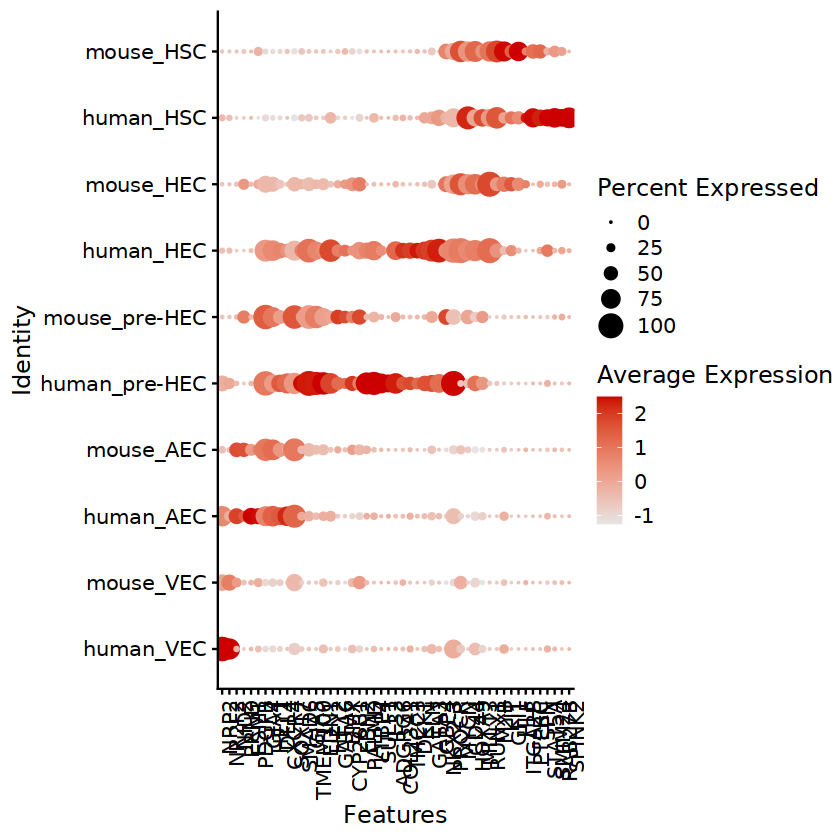

In [16]:
# plot EHT markers on the integrated data
sample$celltype_species <- factor(sample$celltype_species, levels = c("human_VEC","mouse_VEC","human_AEC","mouse_AEC","human_pre-HEC","mouse_pre-HEC","human_HEC","mouse_HEC","human_HSC","mouse_HSC"))

DotPlot(sample, features = EHT_scorecard, cols = c("grey90", "red3"), assay = "SCT", group.by = "celltype_species") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/dotplot_EHT_integrated_by_species.pdf", width = 13.5, height = 4.5)

In [17]:
# plot selected markers
marker_selected <- c("ACE","IL33","SULF1","CD44","KIT","SPINK2","IKZF2")
for(gene in marker_selected){
    FeaturePlot(sample, features=gene, cols=c("grey90","red3"), reduction="umap", min.cutoff = 0, split.by = "orig.ident", keep.scale = "all")
    ggsave(paste("figure/EHT_TE", gene, "split_by_species.pdf", sep = "_"), width = 9, height = 5)
}

In [18]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12       ggrepel_0.9.3         RColorBrewer_1.1-3   
 [4] Hmisc_5.0-1           Matrix_1.5-4          dplyr_1.1.1          
 [7] ggplot2_3.4.2         harmony_0.1.1         Rcpp_1.0.10          
[10] SeuratDisk_0.0.0.9020 SeuratObject_4.1.3    Seurat_4.3.0         

loaded via a namespace (and not attached):
  [1] uuid_1.1-0                  backports_1.4.1            
  [3] systemfonts_1.0.4    